In [1]:
!pip install tensorflow-gpu

     |████████████████████████████████| 454.3MB 34kB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
import cv2
import tensorflow as tf
from glob import glob
import matplotlib.pyplot as plt

In [4]:
# Create a list with the filepaths for training and testing
IMAGE_SIZE = [224, 224]
dir_ = Path('/content/drive/MyDrive/PFE2021/Test')
train_file_paths = list(dir_.glob(r'**/*.png'))

dir_ = Path('/content/drive/MyDrive/PFE2021/Train')
test_file_paths = list(dir_.glob(r'**/*.png'))

In [5]:
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

In [6]:

train_df = proc_img(train_file_paths)
test_df = proc_img(test_file_paths)

print(f'Number of pictures in the training set: {train_df.shape[0]}')
print(f'Number of pictures in the test set: {test_df.shape[0]}')



print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

Number of pictures in the training set: 1048
Number of pictures in the test set: 4038
Number of different labels: 4

Labels: ['Viral Pneumonia' 'Lung_Opacity' 'Normal' 'COVID']


In [7]:

# The DataFrame with the filepaths in one column and the labels in the other one
train_df.head(10)

,Filepath,Label
0,/content/drive/MyDrive/PFE2021/Test/Viral Pneu...,Viral Pneumonia
1,/content/drive/MyDrive/PFE2021/Test/Viral Pneu...,Viral Pneumonia
2,/content/drive/MyDrive/PFE2021/Test/Lung_Opaci...,Lung_Opacity
3,/content/drive/MyDrive/PFE2021/Test/Viral Pneu...,Viral Pneumonia
4,/content/drive/MyDrive/PFE2021/Test/Normal/Nor...,Normal
5,/content/drive/MyDrive/PFE2021/Test/Lung_Opaci...,Lung_Opacity
6,/content/drive/MyDrive/PFE2021/Test/Lung_Opaci...,Lung_Opacity
7,/content/drive/MyDrive/PFE2021/Test/Lung_Opaci...,Lung_Opacity
8,/content/drive/MyDrive/PFE2021/Test/COVID/COVI...,COVID
9,/content/drive/MyDrive/PFE2021/Test/COVID/COVI...,COVID


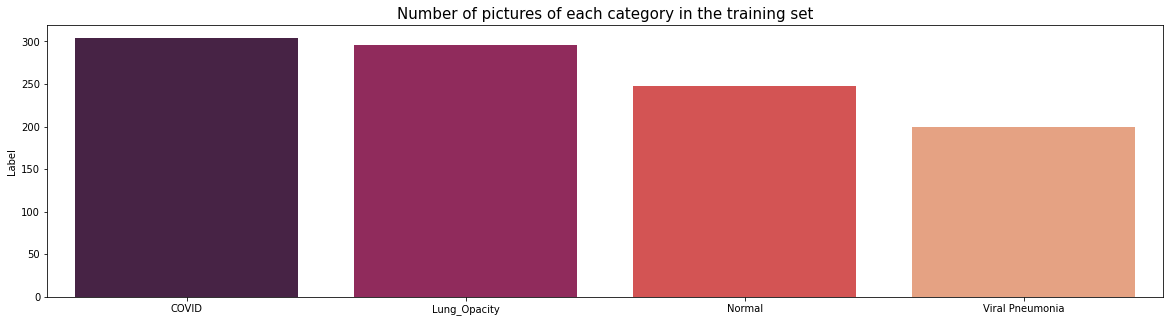

In [8]:
# Display the number of pictures of each category in the training set
import seaborn as sns
vc = train_df['Label'].value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x = sorted(vc.index), y = vc, palette = "rocket")
plt.title("Number of pictures of each category in the training set", fontsize = 15)
plt.show()

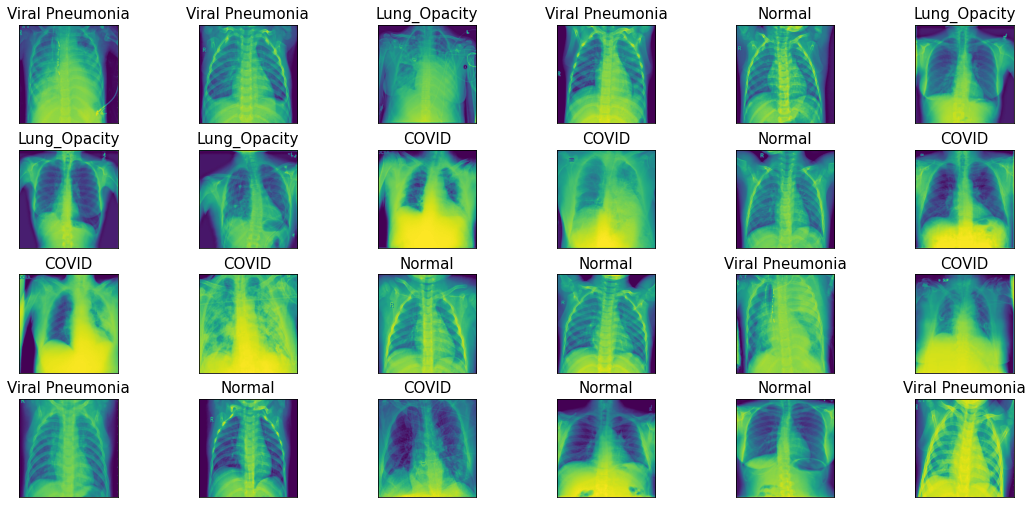

In [9]:
# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_df.Filepath[i]))
    ax.set_title(train_df.Label[i], fontsize = 15)
plt.tight_layout(pad=0.5)
plt.show()


In [10]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 0s 0us/step


In [11]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
for layer in vgg.layers:
    layer.trainable = False

In [13]:
folders = glob('/content/drive/MyDrive/KHOULOUD/Train/*')

folders

['/content/drive/MyDrive/KHOULOUD/Train/Lung_Opacity',
 '/content/drive/MyDrive/KHOULOUD/Train/COVID',
 '/content/drive/MyDrive/KHOULOUD/Train/Normal',
 '/content/drive/MyDrive/KHOULOUD/Train/Viral Pneumonia']

In [14]:
x = Flatten()(vgg.output)

In [15]:
prediction = Dense(len(folders), activation='softmax')(x)

In [16]:
model = Model(inputs = vgg.input, outputs = prediction)

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [20]:
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/PFE2021/Train', target_size = (224, 224),
                                                 batch_size = 32, class_mode = 'categorical')


Found 4038 images belonging to 4 classes.


In [21]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/PFE2021/Test', target_size = (224, 224),
                                            batch_size = 32, class_mode = 'categorical')

Found 1048 images belonging to 4 classes.


In [22]:
 vgg_model = model.fit_generator(training_set, validation_data = test_set, epochs = 10, steps_per_epoch = len(training_set),
  validation_steps = len(test_set))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
127/127 [==============================] - 2662s 21s/step - loss: 0.5854 - accuracy: 0.7828 - val_loss: 0.5525 - val_accuracy: 0.8168
Epoch 2/10
127/127 [==============================] - 2602s 21s/step - loss: 0.3283 - accuracy: 0.8774 - val_loss: 0.3524 - val_accuracy: 0.8769
Epoch 3/10
127/127 [==============================] - 2607s 21s/step - loss: 0.2919 - accuracy: 0.8910 - val_loss: 0.3191 - val_accuracy: 0.8721
Epoch 4/10
127/127 [==============================] - 2609s 21s/step - loss: 0.2748 - accuracy: 0.8980 - val_loss: 0.4170 - val_accuracy: 0.8292
Epoch 5/10
127/127 [==============================] - 2639s 21s/step - loss: 0.2645 - accuracy: 0.9017 - val_loss: 0.2643 - val_accuracy: 0.9027
Epoch 6/10
127/127 [==============================] - 2610s 21s/step - loss: 0.2448 - accuracy: 0.9116 - val_loss: 0.2206 - val_accuracy: 0.9160
Epoch 7/10
127/127 [==============================] - 2608s 21s/step - loss: 0.2197 - accuracy: 0.9217 - val_loss: 0.2175 - val_ac

In [23]:
vgg_model.history  

{'accuracy': [0.7828132510185242,
  0.8774145841598511,
  0.8910351395606995,
  0.8979693055152893,
  0.9016839861869812,
  0.9115899205207825,
  0.9217434525489807,
  0.8992075324058533,
  0.9227340221405029,
  0.9361069798469543],
 'loss': [0.5853762626647949,
  0.3282959461212158,
  0.29192277789115906,
  0.27481162548065186,
  0.2644970118999481,
  0.24481454491615295,
  0.21968820691108704,
  0.2755298316478729,
  0.19920994341373444,
  0.1770174503326416],
 'val_accuracy': [0.8167939186096191,
  0.8769084215164185,
  0.8721374273300171,
  0.8291984796524048,
  0.902671754360199,
  0.9160305261611938,
  0.9217557311058044,
  0.9131679534912109,
  0.9179389476776123,
  0.9093511700630188],
 'val_loss': [0.552467942237854,
  0.3523571491241455,
  0.31913888454437256,
  0.41698649525642395,
  0.2642703652381897,
  0.22062905132770538,
  0.21753762662410736,
  0.23788253962993622,
  0.21847736835479736,
  0.2513618469238281]}

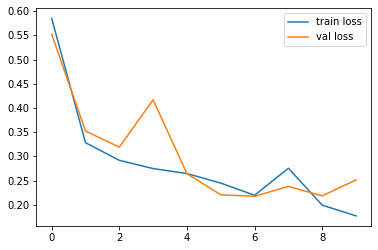

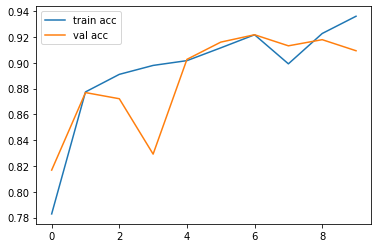

<Figure size 432x288 with 0 Axes>

In [24]:
# plot the loss
plt.plot(vgg_model.history['loss'], label='train loss')
plt.plot(vgg_model.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(vgg_model.history['accuracy'], label='train acc')
plt.plot(vgg_model.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc') 

In [27]:
from tensorflow.keras.models import load_model
model.save('vgg_PFE2021.h5')


In [28]:
y_pred = model.predict(test_set)
y_pred


array([[9.3373848e-04, 2.4634774e-04, 9.9587327e-01, 2.9466425e-03],
       [1.4120346e-04, 8.7270600e-06, 9.9941087e-01, 4.3928306e-04],
       [2.7949164e-02, 5.4640794e-01, 4.2564216e-01, 6.8839296e-07],
       ...,
       [8.6678565e-06, 4.7312884e-08, 9.9997377e-01, 1.7570541e-05],
       [4.4180416e-02, 9.5577610e-01, 8.3857958e-06, 3.5048750e-05],
       [9.8603535e-01, 1.3958439e-02, 5.8044211e-06, 4.3258356e-07]],
      dtype=float32)

In [29]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([2, 2, 1, ..., 2, 1, 0])

Text(0.5, 1.0, 'Viral Pneumonia')

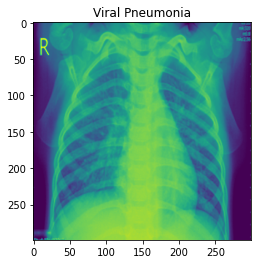

In [36]:


plt.imshow(plt.imread("/content/drive/MyDrive/PFE2021/Test/Viral Pneumonia/Viral Pneumonia-101.png"))
plt.title('Viral Pneumonia')

Text(0.5, 1.0, 'COVID-19')

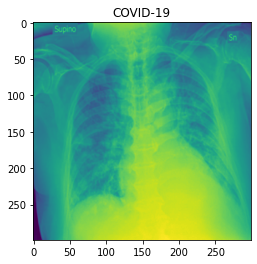

In [37]:
plt.imshow(plt.imread("/content/drive/MyDrive/PFE2021/Test/COVID/COVID-10.png"))
plt.title('COVID-19')



Text(0.5, 1.0, 'Lung_Opacity')

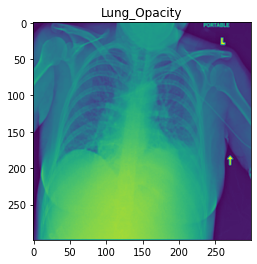

In [38]:
plt.imshow(plt.imread("/content/drive/MyDrive/PFE2021/Test/Lung_Opacity/Lung_Opacity-4824.png"))
plt.title('Lung_Opacity')



Text(0.5, 1.0, 'Normal')

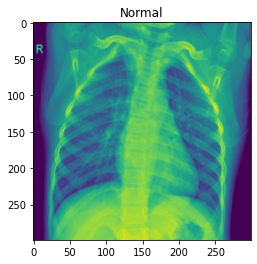

In [39]:
plt.imshow(plt.imread("/content/drive/MyDrive/PFE2021/Test/Normal/Normal-100.png"))
plt.title('Normal')

In [40]:
vgg_load = load_model('vgg_PFE2021.h5')

In [41]:
def prepare(filepath):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR) # Reading the file
    img_array = img_array / 255
    new_array = cv2.resize(img_array, (224, 224)) # resizing the img_array to (224,224)
    return new_array.reshape(-1, 224, 224, 3) # reshaping the new data


In [42]:
model = tf.keras.models.load_model("vgg_PFE2021.h5")

In [43]:
prediction = model.predict([prepare("/content/drive/MyDrive/PFE2021/Train/COVID/COVID-1000.png")])
np.argmax(prediction)


0

In [44]:
class_dict = training_set.class_indices
class_dict

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}

In [45]:
if np.argmax(prediction) == 0:
    print("COVID-19")
elif np.argmax(prediction) == 1:
    print("Lung_Opacity")
elif np.argmax(prediction) == 2:
    print("TNormal")
else:
    print("Viral Pneumonia")

COVID-19
